In [16]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"train.csv")

# Keep only needed columns
df = df[["image_link", "price"]]

# Drop missing data if any
df = df.dropna(subset=["image_link", "price"])

# Select only first 1000 rows (or sample randomly)
df = df.head(1000)
test_df  = df.iloc[1000:1200].reset_index(drop=True) 
# OR random sample:
# df = df.sample(n=1000, random_state=42).reset_index(drop=True)

print(df.shape)

(1000, 2)


In [2]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 800
Validation samples: 200


In [3]:
import tensorflow as tf
import requests

IMG_SIZE = (224, 224)

def fetch_image_from_url(url):
    """Fetch and preprocess an image from a URL."""
    try:
        # Convert TF string to normal Python string
        url = url.numpy().decode("utf-8")

        response = requests.get(url, timeout=10)
        image = tf.image.decode_jpeg(response.content, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = image / 255.0
    except Exception:
        # Return a blank image if loading fails
        image = tf.ones((*IMG_SIZE, 3))
    return image

def load_data(image_url, price):
    """Wrapper for TensorFlow dataset mapping."""
    image = tf.py_function(func=fetch_image_from_url, inp=[image_url], Tout=tf.float32)
    image.set_shape((*IMG_SIZE, 3))
    return image, tf.cast(price, tf.float32)


In [4]:
# Convert pandas columns to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_link"].values, train_df["price"].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["image_link"].values, val_df["price"].values))

# Apply the preprocessing function
train_ds = train_ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch for performance
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [5]:
# Inspect one batch to verify everything works
for images, prices in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First few prices:", prices[:5].numpy())


Image batch shape: (16, 224, 224, 3)
First few prices: [ 19.845   3.38   13.81  140.75   38.92 ]


Sample index: 601
Image URL: https://m.media-amazon.com/images/I/71Z1b09O3gL.jpg
Target price: 22.93


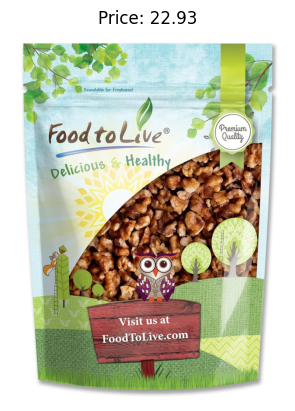

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Pick one random sample from the training dataset
sample_idx = random.randint(0, len(train_df) - 1)
sample_url = train_df.iloc[sample_idx]["image_link"]
sample_price = train_df.iloc[sample_idx]["price"]

print(f"Sample index: {sample_idx}")
print(f"Image URL: {sample_url}")
print(f"Target price: {sample_price}")

# Fetch and display the image manually
import requests
from PIL import Image
from io import BytesIO

try:
    response = requests.get(sample_url, timeout=10)
    image = Image.open(BytesIO(response.content)).convert("RGB")
except Exception as e:
    print("Error loading image:", e)
    image = Image.new("RGB", (224, 224), (255, 255, 255))

plt.imshow(np.array(image))
plt.axis("off")
plt.title(f"Price: {sample_price}")
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import EfficientNetV2B0

# --- Pretrained EfficientNetV2 Backbone ---
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# --- Freeze all but last few convolutional layers ---
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# --- Build regression model ---
model = models.Sequential([
    base_model,

    # Max pooling instead of Global Average Pooling
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    layers.Flatten(),

    # ANN head
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),

    # Output layer for regression
    layers.Dense(1)
])

# --- Compile the model ---
optimizer = optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     5,898,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,982,417 (45.71 MB)

 Trainable params: 6,880,945 (26.25 MB)

 Non-trainable params: 5,101,472 (19.46 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,             # stop after 3 epochs of no improvement
    restore_best_weights=True
)


In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - loss: 1128.5264 - mae: 19.7905 - val_loss: 1158.4122 - val_mae: 19.6791
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - loss: 1032.1650 - mae: 19.0791 - val_loss: 1168.2372 - val_mae: 19.4701
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 276s 5s/step - loss: 1024.1504 - mae: 19.0312 - val_loss: 1160.0632 - val_mae: 19.6824
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - loss: 1007.4122 - mae: 19.2316 - val_loss: 1146.9420 - val_mae: 20.2787
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 751s 15s/step - loss: 1016.4596 - mae: 19.1296 - val_loss: 1159.1234 - val_mae: 19.7275
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - loss: 987.6755 - mae: 19.3097 - val_loss: 1141.7144 - val_mae: 20.7084
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - loss: 1022.7926 - mae: 19.3435 - val_loss: 1149.5151 - val_mae: 20.1250
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - loss: 989.9701 - mae: 19.1931 - val_loss: 1151.6837 - val_mae: 19.8522
E